In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys, os  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers, optimizers
import numpy as np

Đọc folder ảnh raw và cắt mặt

In [ ]:
import cv2
import os

face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

folderPaths = ['anger', 'happy', 'neutral', 'sad']
count = 0
for path in folderPaths:
    imagePaths = os.listdir(f"{path}")
    
    for image in imagePaths:
        img = cv2.imread(f"{path}/{image}")
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(gray, 1.3, 5)

        for (x,y,w,h) in faces:

            cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     
            count += 1

            # Save the captured image into the datasets folder
            cv2.imwrite("dataset/User." + path + '.' + str(count) + ".jpg", gray[y:y+h,x:x+w])

- Sau khi load xong dữ liệu và chia dữ liệu thành training và test thì mình cần xử lý dữ liệu và chuyển y thành dạng category:


In [19]:
data = np.load("/content/drive/MyDrive/RecognitionEmoji/dataset.npz")

In [20]:
X = data['X']
Y = data['Y']

In [21]:
X.shape

(1831, 48, 48)

In [22]:
test = X[0]

In [23]:
mean = np.mean(X)
std  = np.std(X)
X = (X-mean)/(std+1e-7)

In [24]:
split = 0.8
sizeData = X.shape[0]

In [25]:
seed = 113
rng = np.random.RandomState(seed) # Dữ nguyên trạng thái random với seed bất kỳ
indices = np.arange(sizeData)
rng.shuffle(indices)
X = X[indices]
Y = Y[indices]

In [26]:
# split dataset to test, train
split = int(sizeData*split)
trainX = X[:split]
testX = X[split:]
trainY = Y[:split]
testY = Y[split:]

In [27]:
num_labels = 4 
batch_size = 16 
epochs = 100 
width, height = 48, 48  


trainX = trainX.reshape(trainX.shape[0], 48, 48, 1)  
testX = testX.reshape(testX.shape[0], 48, 48, 1)

In [40]:
baseMapNum = 32
weight_decay = 1e-5

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay), input_shape=trainX.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l1_l2(weight_decay, weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_labels, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)       

- B4: Training mô hình

In [34]:
#training
batch_size = 256
epochs = 300
steps = trainX.shape[0] // batch_size

boundaries = [steps*50, steps*50]
values = [0.002, 0.001, 0.0005]
schedules = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
opt_adam  = keras.optimizers.Adam(learning_rate=schedules)

In [35]:
# data augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
test_dataset  = tf.data.Dataset.from_tensor_slices((testX, testY))

def process_data(image, label):
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_crop(image, size=[30, 30, 1])
        image = tf.image.resize(image, (48, 48))

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, 0.2)
    

    return image, label

train_batches = (train_dataset.shuffle(256*4)
                              .map(process_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                              .batch(batch_size)
                              .prefetch(tf.data.experimental.AUTOTUNE) )

test_dataset = (test_dataset.batch(batch_size))

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
history = model.fit(train_batches, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/300
6/6 [==============================] - 2s 128ms/step - loss: 0.9732 - accuracy: 0.7792 - val_loss: 1.2163 - val_accuracy: 0.7711
Epoch 2/300
6/6 [==============================] - 0s 63ms/step - loss: 0.9875 - accuracy: 0.7268 - val_loss: 1.1617 - val_accuracy: 0.7711
Epoch 3/300
6/6 [==============================] - 0s 64ms/step - loss: 0.8444 - accuracy: 0.7704 - val_loss: 1.1514 - val_accuracy: 0.7738
Epoch 4/300
6/6 [==============================] - 0s 64ms/step - loss: 0.7619 - accuracy: 0.8066 - val_loss: 1.0746 - val_accuracy: 0.7711
Epoch 5/300
6/6 [==============================] - 0s 64ms/step - loss: 0.7947 - accuracy: 0.7873 - val_loss: 1.0744 - val_accuracy: 0.7575
Epoch 6/300
6/6 [==============================] - 0s 65ms/step - loss: 0.6963 - accuracy: 0.8303 - val_loss: 1.1455 - val_accuracy: 0.7602
Epoch 7/300
6/6 [==============================] - 0s 63ms/step - loss: 0.7052 - accuracy: 0.8248 - val_loss: 1.0170 - val_accuracy: 0.7575
Epoch 8/300
6/6 [==

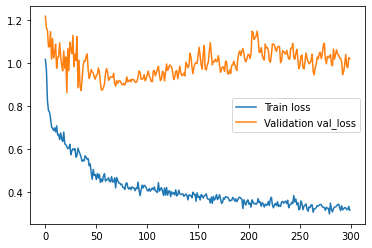

In [36]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Validation val_loss')
plt.legend()


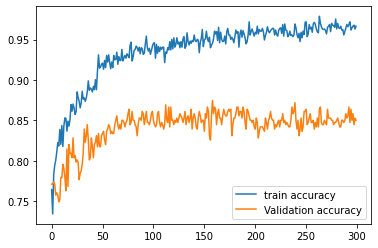

In [37]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

In [39]:
#Các bạn thảo luận kĩ hơn về các kĩ thuật training mô hình để tránh overfitting.overfitting.
#Saving the  model 
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)  
model.save_weights("fer.h5")